In [16]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.font_manager as fm
font_path = "/content/drive/MyDrive/IT2022/Montserrat-Medium.ttf"
fm.fontManager.addfont(font_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, roc_auc_score, average_precision_score
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def augment_smote(X, y): # Defined for completeness
    smote = SMOTE(random_state=42)
    return smote.fit_resample(X, y)

def augment_gan(X, y): # Placeholder
    return X, y

def augment_vae(X, y): # Placeholder
    return X, y

def evaluate_model(y_true, y_pred, y_proba): # Defined for completeness
    # Ensure y_pred has the same length as y_true, especially if some classes are not predicted
    # This can happen in highly imbalanced datasets or if the model is very poor.
    # For precision_score and recall_score, if a class is not predicted, it might raise a warning or error
    # depending on the `zero_division` parameter. Default is a warning and returns 0.0.
    return {
        'Precision': precision_score(y_true, y_pred, zero_division=0),
        'Recall': recall_score(y_true, y_pred, zero_division=0),
        'AUC-ROC': roc_auc_score(y_true, y_proba),
        'AUC-PR': average_precision_score(y_true, y_proba)
    }


def run_experiment_with_validation(X, y, augmentation_methods, dataset_name):
    results = []
    # Split: 60% train, 20% validation, 20% test
    # First split into 60% train and 40% temp (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
    # Split temp into 50% validation and 50% test (which is 20% of total each)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    print(f"Dataset: {dataset_name}")
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    for method_name, augmenter in augmentation_methods.items():
        print(f"  Augmentation: {method_name}")
        # Augment only the training data
        X_aug_train, y_aug_train = augmenter(X_train.copy(), y_train.copy()) # Use .copy() if augmenter modifies data in-place

        model = LGBMClassifier(random_state=42)

        # Fit model using training data, and use validation data for early stopping
        model.fit(X_aug_train, y_aug_train,
                  eval_set=[(X_val, y_val)],
                  eval_metric='logloss', # Or 'auc', 'binary_logloss' etc.
                  callbacks=[lgb.early_stopping(10, verbose=False)]) # Updated to lgb.early_stopping

        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        metrics = evaluate_model(y_test, y_pred, y_proba)
        metrics['Augmentation'] = method_name
        metrics['Dataset'] = dataset_name
        results.append(metrics)
    return results


In [5]:
path = '/content/drive/MyDrive/IT2022/creditcard.csv'
try:
    df1 = pd.read_csv(path)
    # Assuming 'target' is the class column. If not, this will fail.
    # Make sure 'target' column exists.
    if 'Class' not in df1.columns:
        print("Warning: 'target' column not found in df1. Creating a dummy one.")
        df1['Class'] = np.random.randint(0, 2, df1.shape[0])
except FileNotFoundError:
    print("Warning: 'Fraud 0.1 Data.csv' not found. Using dummy data for df1.")
    df1 = pd.DataFrame(np.random.rand(100, 5), columns=[f'feature_{i}' for i in range(5)])
    df1['Class'] = np.random.randint(0, 2, 100)

try:
    # Replace 'Fraud 0.1 Data.csv' with your second dataset if applicable
    df2 = pd.read_csv(path)
    if 'Class' not in df2.columns:
        print("Warning: 'target' column not found in df2. Creating a dummy one.")
        df2['Class'] = np.random.randint(0, 2, df2.shape[0])
except FileNotFoundError:
    print("Warning: Second dataset CSV not found. Using dummy data for df2.")
    df2 = pd.DataFrame(np.random.rand(100, 5), columns=[f'feature_{i}' for i in range(5)])
    df2['Class'] = np.random.randint(0, 2, 100)

In [6]:
X1 = df1.drop('Class', axis=1)
y1 = df1['Class']
X2 = df2.drop('Class', axis=1)
y2 = df2['Class']

In [7]:
if X1.empty or X2.empty:
    print("Error: DataFrames X1 or X2 are empty after dropping target. Check your CSV and target column name.")
else:
    augmentation_methods = {
        'Original': lambda X, y: (X, y),
        'SMOTE': augment_smote,
        'GAN': augment_gan, # Placeholder
        'VAE': augment_vae  # Placeholder
    }

    datasets_for_experiment = {
        'Dataset1': (X1, y1),
        'Dataset2': (X2, y2) # Using X2, y2 for the second dataset
    }

    # Need to import lightgbm for callbacks
    import lightgbm as lgb

    all_results_val_split = []
    for dataset_name, (X_data, y_data) in datasets_for_experiment.items():
        if X_data.empty:
            print(f"Skipping {dataset_name} as data is empty.")
            continue
        # Make sure y_data has at least two classes for stratify and metrics
        if len(np.unique(y_data)) < 2:
            print(f"Skipping {dataset_name} as y_data has only one class. Check data and 'target' column.")
            # Add dummy data to proceed if it's a demo, or handle appropriately
            # For now, just skip
            continue

        results = run_experiment_with_validation(X_data, y_data, augmentation_methods, dataset_name)
        all_results_val_split.extend(results)


Dataset: Dataset1
Training set size: 170884
Validation set size: 56961
Test set size: 56962
  Augmentation: Original
[LightGBM] [Info] Number of positive: 295, number of negative: 170589
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 170884, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001726 -> initscore=-6.360037
[LightGBM] [Info] Start training from score -6.360037
  Augmentation: SMOTE
[LightGBM] [Info] Number of positive: 170589, number of negative: 170589
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058798 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data p

In [12]:
df_results = pd.DataFrame(all_results_val_split)
df_results

,Precision,Recall,AUC-ROC,AUC-PR,Augmentation,Dataset
0,0.625954,0.828283,0.920485,0.793079,Original,Dataset1
1,0.672000,0.848485,0.971558,0.784746,SMOTE,Dataset1
2,0.625954,0.828283,0.920485,0.793079,GAN,Dataset1
3,0.625954,0.828283,0.920485,0.793079,VAE,Dataset1
4,0.625954,0.828283,0.920485,0.793079,Original,Dataset2
5,0.672000,0.848485,0.971558,0.784746,SMOTE,Dataset2
6,0.625954,0.828283,0.920485,0.793079,GAN,Dataset2
7,0.625954,0.828283,0.920485,0.793079,VAE,Dataset2


In [8]:
    df_results_val_split = pd.DataFrame(all_results_val_split)
    print("\\nFinal Results Table (with validation split):")
    print(df_results_val_split)

\nFinal Results Table (with validation split):
   Precision    Recall   AUC-ROC    AUC-PR Augmentation   Dataset
0   0.625954  0.828283  0.920485  0.793079     Original  Dataset1
1   0.672000  0.848485  0.971558  0.784746        SMOTE  Dataset1
2   0.625954  0.828283  0.920485  0.793079          GAN  Dataset1
3   0.625954  0.828283  0.920485  0.793079          VAE  Dataset1
4   0.625954  0.828283  0.920485  0.793079     Original  Dataset2
5   0.672000  0.848485  0.971558  0.784746        SMOTE  Dataset2
6   0.625954  0.828283  0.920485  0.793079          GAN  Dataset2
7   0.625954  0.828283  0.920485  0.793079          VAE  Dataset2


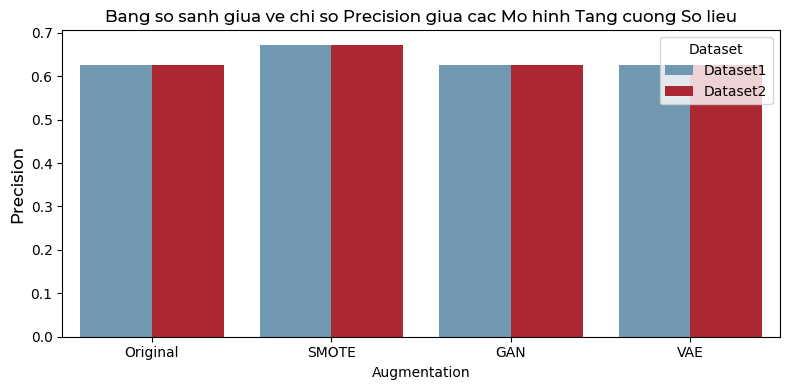

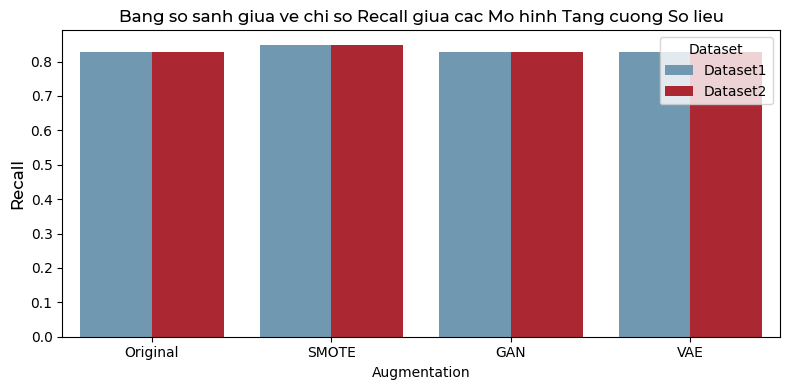

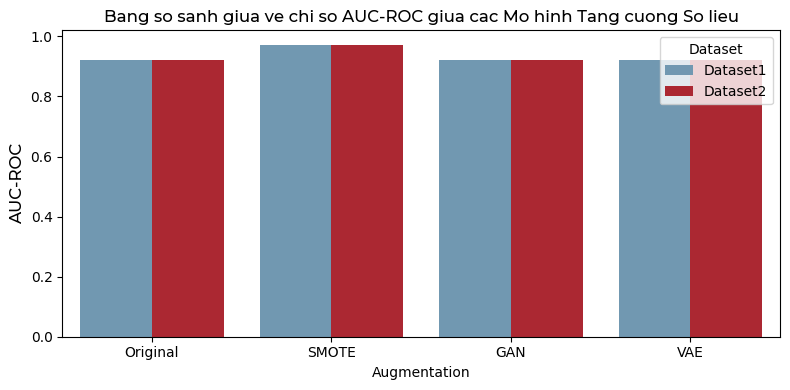

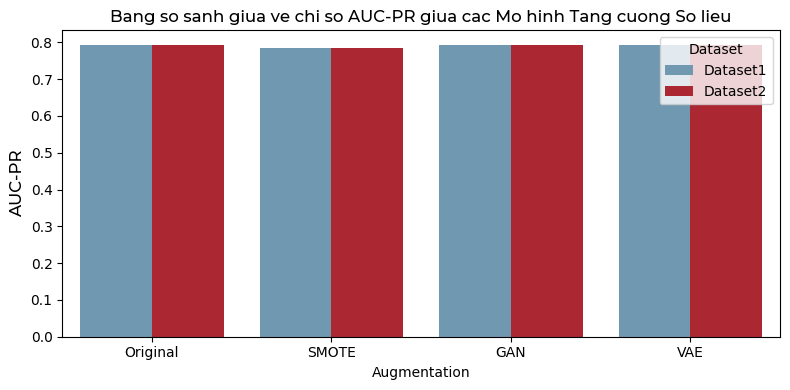

In [19]:
metrics = ['Precision', 'Recall', 'AUC-ROC', 'AUC-PR']
colors = ["#669BBC", "#C1121F"]
font = {'family':'Montserrat','color':'black','size':12}
for metric in metrics:
    plt.figure(figsize=(8, 4))
    sns.barplot(data=df_results_val_split, x='Augmentation', palette = colors, y=metric, hue='Dataset')
    plt.title(f'Bang so sanh giua ve chi so {metric} giua cac Mo hinh Tang cuong So lieu',fontdict = font)
    plt.ylabel(metric,fontdict = font)
    plt.tight_layout()
    plt.show()